In [1]:
from astropy.table import Table
from memory_profiler import memory_usage
from astropy.io import fits
import astropy.units as u
from spec_id import Scale_model,Oldest_galaxy, Median_w_Error_cont
from astropy.cosmology import Planck13, z_at_value
from scipy.interpolate import interp1d, interp2d
from scipy.ndimage import interpolation
import matplotlib.pyplot as plt
from glob import glob
import grizli.model
import seaborn as sea
import numpy as np
import pandas as pd
import sys
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
from time import time
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [6]:
galDB = pd.read_pickle('../data/upd_galDB.pkl')

metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [17]:
def Calzetti(Av,lam):
    lam = lam * 1E-4
    Rv=4.05
    k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
    cal = 10**(-0.4*k*Av/Rv)    
    
    return cal

In [18]:
class Gen_spec(object):
    def __init__(self, galaxy_id, redshift,minwv = 7900, maxwv = 11200, shift = 1):
        self.galaxy_id = galaxy_id
        self.gid = int(self.galaxy_id[1:])
        self.redshift = redshift
        self.shift = shift

        """ 
        self.flt_input - grism flt (not image flt) which contains the object you're interested in modeling, this
                         will tell Grizli the PA
        **
        self.galaxy_id - used to id galaxy and import spectra
        **
        self.pad - Grizli uses this to add extra pixels to the edge of an image to account for galaxies near the 
                   edge, 100 is usually enough
        **
        self.beam - information used to make models
        **
        self.wv - output wavelength array of simulated spectra
        **
        self.fl - output flux array of simulated spectra
        """
        if self.galaxy_id == 's35774':
            maxwv = 11000
            
        gal_wv, gal_fl, gal_er = np.load(glob('../spec_stacks/*{0}*'.format(self.gid))[0])
        self.flt_input = glob('../beams/*{0}*'.format(self.gid))[0]

        IDX = [U for U in range(len(gal_wv)) if minwv <= gal_wv[U] <= maxwv]

        self.gal_wv_rf = gal_wv[IDX] / (1 + self.redshift)
        self.gal_wv = gal_wv[IDX]
        self.gal_fl = gal_fl[IDX]
        self.gal_er = gal_er[IDX]

        self.gal_wv_rf = self.gal_wv_rf[self.gal_fl > 0 ]
        self.gal_wv = self.gal_wv[self.gal_fl > 0 ]
        self.gal_er = self.gal_er[self.gal_fl > 0 ]
        self.gal_fl = self.gal_fl[self.gal_fl > 0 ]

        ## Spectrum cutouts
        self.beam = grizli.model.BeamCutout(fits_file=self.flt_input)

        ## Get sensitivity function
        
        flat = self.beam.flat_flam.reshape(self.beam.beam.sh_beam)
        fwv, ffl, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,flat.shape[0]]),flat.T[:-1],axis=0).T , bin=0)
        IDT = [U for U in range(len(fwv)) if 7800 <= fwv[U] <= 11500] 
        self.IDT = IDT
        self.filt = interp1d(fwv, ffl)(self.gal_wv)
        
    def Sim_spec(self, metal, age, tau, model_redshift = 0, dust = 0):
        if model_redshift ==0:
            model_redshift = self.redshift
            
        model = '../../../fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(metal, age, tau)

        wave, fl = np.load(model)            
            
        cal = 1
        if dust !=0:
            lam = wave * 1E-4
            Rv = 4.05
            k = 2.659*(-2.156 +1.509/(lam) -0.198/(lam**2) +0.011/(lam**3)) + Rv
            cal = 10**(-0.4 * k * dust / Rv)  
        
        ## Compute the models
        self.beam.compute_model(spectrum_1d=[wave*(1+model_redshift),fl * cal])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,self.beam.model.shape[0]]),
                                                           self.beam.model.T[:-1],axis=0).T , bin=0)

        ifl = interp1d(w, f)(self.gal_wv)
        adj_ifl = ifl /self.filt
        
        C = Scale_model(self.gal_fl, self.gal_er, adj_ifl)

        self.fl = C * adj_ifl

    def Sim_spec_mult(self, wave, fl, model_redshift = 0):
        if model_redshift ==0:
            model_redshift = self.redshift

        ## Compute the models
        self.beam.compute_model(spectrum_1d=[wave*(1+model_redshift), fl])

        ## Extractions the model (error array here is meaningless)
        w, f, e = self.beam.beam.optimal_extract(np.append(np.zeros([self.shift,self.beam.model.shape[0]]),
                                                           self.beam.model.T[:-1],axis=0).T , bin=0)

        self.fl = f[self.IDT]
        self.mwv = w[self.IDT]

In [19]:
def Scale_model_mult(D, sig, M):
    C = np.sum(((D * M) / sig ** 2), axis=1) / np.sum((M ** 2 / sig ** 2), axis=1)
    return C

In [21]:
def Galaxy_full_fit(metal, age, tau, rshift, specz, galaxy, name, minwv = 8000, maxwv = 11200):
    #############Read in spectra#################
    spec = Gen_spec(galaxy, specz, minwv = minwv, maxwv = maxwv)

    #### apply special mask for specific objects

    if galaxy == 's47677':
        IDer = []
        for ii in range(len(spec.gal_wv_rf)):
            if 4845 <= spec.gal_wv_rf[ii] <= 4863:
                IDer.append(ii)
        spec.gal_er[IDer] = 1E8
        spec.gal_fl[IDer] = 0

    if galaxy == 's39170' or galaxy == 'n34694':
        IDer = []
        for ii in range(len(spec.gal_wv_rf)):
            if 4865 <= spec.gal_wv_rf[ii] <= 4885:
                IDer.append(ii)
        spec.gal_er[IDer] = 1E8
        spec.gal_fl[IDer] = 0

    ##############Create chigrid and add to file#################
    for i in range(len(metal)):
        mfl = np.zeros([len(age)*len(tau)*len(rshift),len(spec.IDT)])
        for ii in range(len(age)):
            for iii in range(len(tau)):
                wv,fl = np.load('../../../fsps_models_for_fit/fsps_spec/m{0}_a{1}_dt{2}_spec.npy'.format(
                                        metal[i], age[ii], tau[iii]))
                for iv in range(len(rshift)):
                    spec.Sim_spec_mult(wv,fl,rshift[iv])
                    mfl[ii*len(tau)*len(rshift) + iii*len(rshift) + iv] = spec.fl
        np.save('../chidat/spec_files/{0}_m{1}'.format(name, metal[i]),mfl)

In [5]:
mtest=np.round(np.arange(0.002,0.031,0.008),3)
atest=np.arange(.5,6.1,.5)
tau_test=[0,8.0, 8.3, 8.48, 8.6]
# ztest = np.array([1.216,1.217,1.218,1.219,1.220])
ztest = np.array([1.219,1.220])

In [28]:
4 / (len(age)*len(tau)*len(ztest)) * (len(age)*len(tau)*41) * len(metal)

2378.0

In [22]:
start = time()
# Galaxy_full_fit(mtest,age,tau,ztest,galDB.z_grism[20],galDB.gids[20],'all_test')
Galaxy_full_fit(mtest,age,tau,ztest,galDB.z_grism[20],galDB.gids[20],'all_test')
end = time()
print(end - start)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

54.06629300117493


In [23]:
def Galaxy_full_analyze(metal, age, tau, rshift, specz, galaxy, name, minwv = 8000, maxwv = 11200):
    Redden_and_stich(galaxy,name,metal, specz, rshift,minwv, maxwv)
    grids = ['../chidat/{0}_d{1}_chidata.npy'.format(name,U) for U in range(11)]
    
    P, PZ, Pt, Ptau, Pz, Pd = Analyze_full_fit(grids, metal, age, tau, rshift)

    np.save('../chidat/%s_tZ_pos' % name,P)
    np.save('../chidat/%s_Z_pos' % name,[metal,PZ])
    np.save('../chidat/%s_t_pos' % name,[age,Pt])
    np.save('../chidat/%s_tau_pos' % name,[np.append(0, np.power(10, np.array(tau)[1:] - 9)),Ptau])
    np.save('../chidat/%s_rs_pos' % name,[rshift,Pz])
    np.save('../chidat/%s_d_pos' % name,[np.arange(0,1.1,0.1),Pd])

In [94]:
len(metal)

29

In [26]:
start = time()
Galaxy_full_analyze(mtest,age,tau,ztest,galDB.z_grism[20],galDB.gids[20],'all_test')
end = time()
print(end - start)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: divide by zero encountered in true_divide
  self.op

2.0056450366973877


In [24]:
def Stich_spec(grids):
    stc = []
    for i in range(len(grids)):
        stc.append(np.load(grids[i]))
        
    stc = np.array(stc)
    return stc.reshape([stc.shape[0] * stc.shape[1],stc.shape[2]])

def Redden_and_stich(galaxy,name,metal,specz, rshift,minwv, maxwv):
    #############Read in spectra#################
    spec = Gen_spec(galaxy, specz, minwv = minwv, maxwv = maxwv)

    #### apply special mask for specific objects

    if galaxy == 's47677':
        IDer = []
        for ii in range(len(spec.gal_wv_rf)):
            if 4845 <= spec.gal_wv_rf[ii] <= 4863:
                IDer.append(ii)
        spec.gal_er[IDer] = 1E8
        spec.gal_fl[IDer] = 0

    if galaxy == 's39170' or galaxy == 'n34694':
        IDer = []
        for ii in range(len(spec.gal_wv_rf)):
            if 4865 <= spec.gal_wv_rf[ii] <= 4885:
                IDer.append(ii)
        spec.gal_er[IDer] = 1E8
        spec.gal_fl[IDer] = 0
    
    wv,fl = np.load('../../../fsps_models_for_fit/fsps_spec/m0.019_a2.0_dt8.0_spec.npy')
    spec.Sim_spec_mult(wv,fl)
    
    files = ['../chidat/spec_files/{0}_m{1}.npy'.format(name,U) for U in metal]
    mfl = Stich_spec(files)
    mfl = np.ma.masked_invalid(mfl)
    mfl.data[mfl.mask] = 0
    mfl = interp2d(spec.mwv,range(len(mfl.data)),mfl.data)(spec.gal_wv,range(len(mfl.data)))
    mfl = mfl / spec.filt
     
    Av = np.arange(0, 1.1, 0.1)
    chifiles = []
    for i in range(len(Av)):
        dust = Calzetti(Av[i],spec.gal_wv_rf)
        redflgrid = mfl * dust
        SCL = Scale_model_mult(spec.gal_fl,spec.gal_er,redflgrid)
        redflgrid = np.array([SCL]).T*redflgrid
        chigrid = np.sum(((spec.gal_fl - redflgrid) / spec.gal_er) ** 2, axis=1).reshape([len(metal), len(age), len(tau), len(rshift)])
        np.save('../chidat/{0}_d{1}_chidata'.format(name, i),chigrid)
        chifiles.append('../chidat/{0}_d{1}_chidata.npy'.format(name, i))

In [25]:
def Stich_grids(grids):
    stc = []
    for i in range(len(grids)):
        stc.append(np.load(grids[i]))
    return np.array(stc)

def Analyze_full_fit(chifiles, metal, age, tau, rshift, dust = np.arange(0,1.1,0.1), age_conv='../data/light_weight_scaling_3.npy'):
    ####### Get maximum age
    max_age = Oldest_galaxy(max(rshift))
    
    ####### Read in file   
    chi = Stich_grids(chifiles)
    
    chi[ : , : , len(age[age <= max_age]):] = 1E5

    ####### Get scaling factor for tau reshaping
    ultau = np.append(0, np.power(10, np.array(tau)[1:] - 9))
    
    convtable = np.load(age_conv)

    overhead = np.zeros([len(tau),metal.size]).astype(int)
    for i in range(len(tau)):
        for ii in range(metal.size):
            amt=[]
            for iii in range(age.size):
                if age[iii] > convtable.T[i].T[ii][-1]:
                    amt.append(1)
            overhead[i][ii] = sum(amt)

    ######## get Pd and Pz
    P_full = np.exp(- chi / 2).astype(np.float128)
    Pd = np.trapz(np.trapz(np.trapz(np.trapz(P_full, rshift, axis=4), ultau, axis=3), age, axis=2), metal, axis=1) /\
        np.trapz(np.trapz(np.trapz(np.trapz(np.trapz(P_full, rshift, axis=4), ultau, axis=3), age, axis=2), metal, axis=1),dust)

    Pz = np.trapz(np.trapz(np.trapz(np.trapz(P_full.T, dust, axis=4), metal, axis=3), age, axis=2), ultau, axis=1) /\
        np.trapz(np.trapz(np.trapz(np.trapz(np.trapz(P_full.T, dust, axis=4), metal, axis=3), age, axis=2), ultau, axis=1),rshift)

    P = np.trapz(P_full, rshift, axis=4)
    P = np.trapz(P.T, dust, axis=3).T
    new_P = np.zeros(P.T.shape)

    ######## Reshape likelihood to get light weighted age instead of age when marginalized
    for i in range(len(tau)):
        frame = np.zeros([metal.size,age.size])
        for ii in range(metal.size):
            dist = interp1d(convtable.T[i].T[ii],P.T[i].T[ii])(age[:-overhead[i][ii]])
            frame[ii] = np.append(dist,np.repeat(0, overhead[i][ii]))
        new_P[i] = frame.T

    ####### Create normalize probablity marginalized over tau
    P = new_P.T

    # test_prob = np.trapz(test_P, ultau, axis=2)
    C = np.trapz(np.trapz(np.trapz(P, ultau, axis=2), age, axis=1), metal)

    P /= C

    prob = np.trapz(P, ultau, axis=2)
    
    # #### Get Z, t, tau, and z posteriors
    PZ = np.trapz(np.trapz(P, ultau, axis=2), age, axis=1)
    Pt = np.trapz(np.trapz(P, ultau, axis=2).T, metal, axis=1)
    Ptau = np.trapz(np.trapz(P.T, metal, axis=2), age, axis=1)

    return prob.T, PZ, Pt, Ptau, Pz, Pd

In [253]:
grids = ['../chidat/all_test_d{0}_chidata.npy'.format(U) for U in range(11)]

In [254]:
f_grid = Stich_grids(grids)

In [255]:
ultau = np.append(0, np.power(10, np.array(tau)[1:] - 9))
dust = np.arange(0,1.1,0.1)

In [256]:
max_age = Oldest_galaxy(max(z_test))

f_grid[ : , : , len(age[age <= max_age]):] = 1E5

In [259]:
convtable = np.load('../data/light_weight_scaling_3.npy')
overhead = np.zeros([len(tau),mtest.size]).astype(int)
for i in range(len(tau)):
    for ii in range(mtest.size):
        amt=[]
        for iii in range(age.size):
            if age[iii] > convtable.T[i].T[ii][-1]:
                amt.append(1)
        overhead[i][ii] = sum(amt)

In [261]:
f_grid.shape

(11, 4, 56, 31, 5)

In [263]:
######## Reshape likelihood to get average age instead of age when marginalized
P_full = np.exp(-f_grid / 2).astype(np.float128)
Pd = np.trapz(np.trapz(np.trapz(np.trapz(P_full, ztest, axis=4), ultau, axis=3), age, axis=2), mtest, axis=1) /\
    np.trapz(np.trapz(np.trapz(np.trapz(np.trapz(P_full, ztest, axis=4), ultau, axis=3), age, axis=2), mtest, axis=1),dust)

Pz = np.trapz(np.trapz(np.trapz(np.trapz(P_full.T, dust, axis=4), mtest, axis=3), age, axis=2), ultau, axis=1) /\
    np.trapz(np.trapz(np.trapz(np.trapz(np.trapz(P_full.T, dust, axis=4), mtest, axis=3), age, axis=2), ultau, axis=1),ztest)

P = np.trapz(P_full, ztest, axis=4)
P = np.trapz(P.T,dust,axis=3).T
new_P = np.zeros(P.T.shape)

for i in range(len(tau)):
    frame = np.zeros([mtest.size,age.size])
    for ii in range(mtest.size):
        dist = interp1d(convtable.T[i].T[ii],P.T[i].T[ii])(age[:-overhead[i][ii]])
        frame[ii] = np.append(dist,np.repeat(0, overhead[i][ii]))
    new_P[i] = frame.T

In [264]:
P.shape

(4, 56, 31)

In [265]:
P = new_P.T

# test_prob = np.trapz(test_P, ultau, axis=2)
C = np.trapz(np.trapz(np.trapz(P, ultau, axis=2), age, axis=1), mtest)

P /= C

# #### Get Z, t, tau, and z posteriors
PZ = np.trapz(np.trapz(P, ultau, axis=2), age, axis=1)
Pt = np.trapz(np.trapz(P, ultau, axis=2).T, mtest,axis=1)
Ptau = np.trapz(np.trapz(P.T, mtest, axis=2), age,axis=1)

In [27]:
Z,PZ = np.load('../chidat/all_test_Z_pos.npy')
t,Pt = np.load('../chidat/all_test_t_pos.npy')
ultau,Ptau = np.load('../chidat/all_test_tau_pos.npy')
z,Pz = np.load('../chidat/all_test_rs_pos.npy')
d,Pd = np.load('../chidat/all_test_d_pos.npy')

In [74]:
Z

array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01 ,
       0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019,
       0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028,
       0.029, 0.03 ])

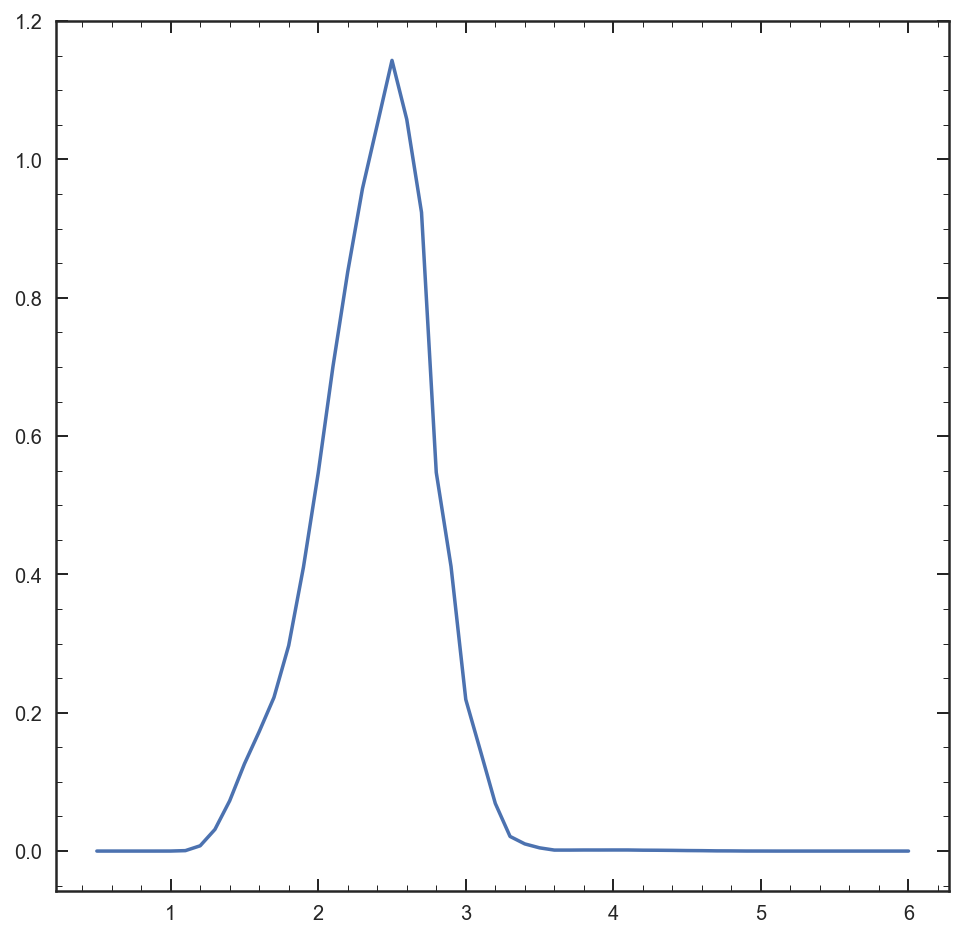

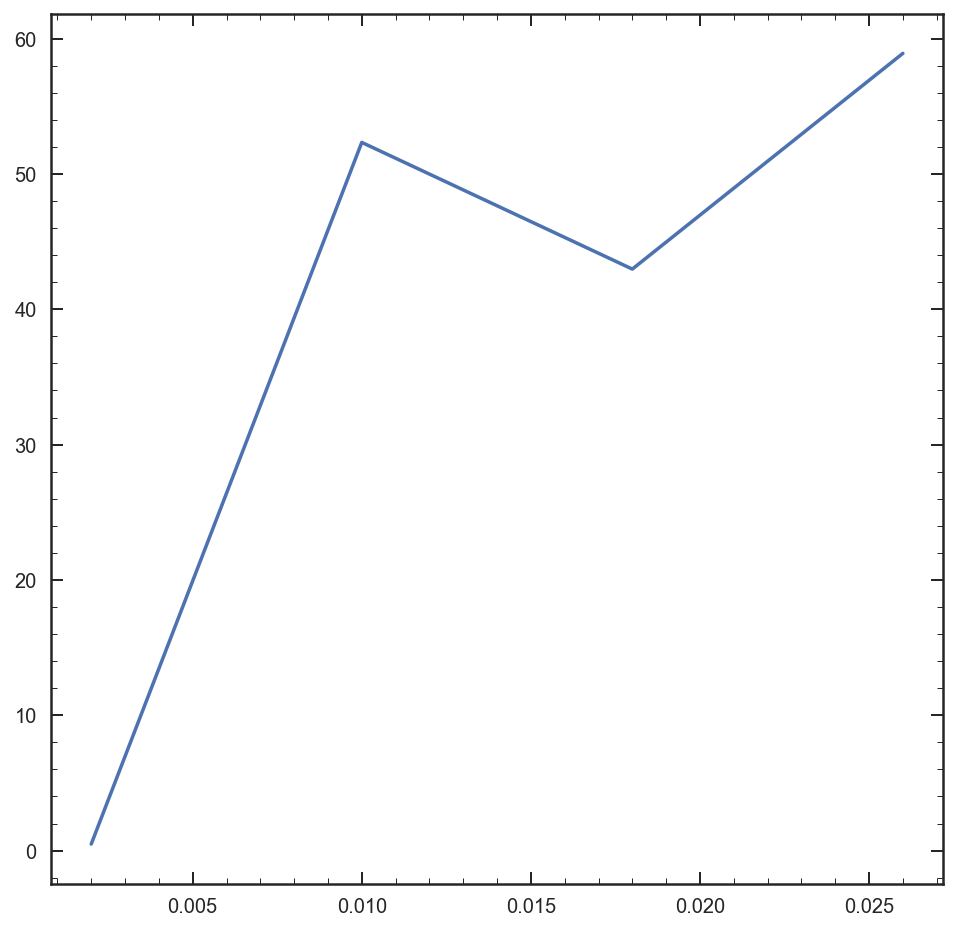

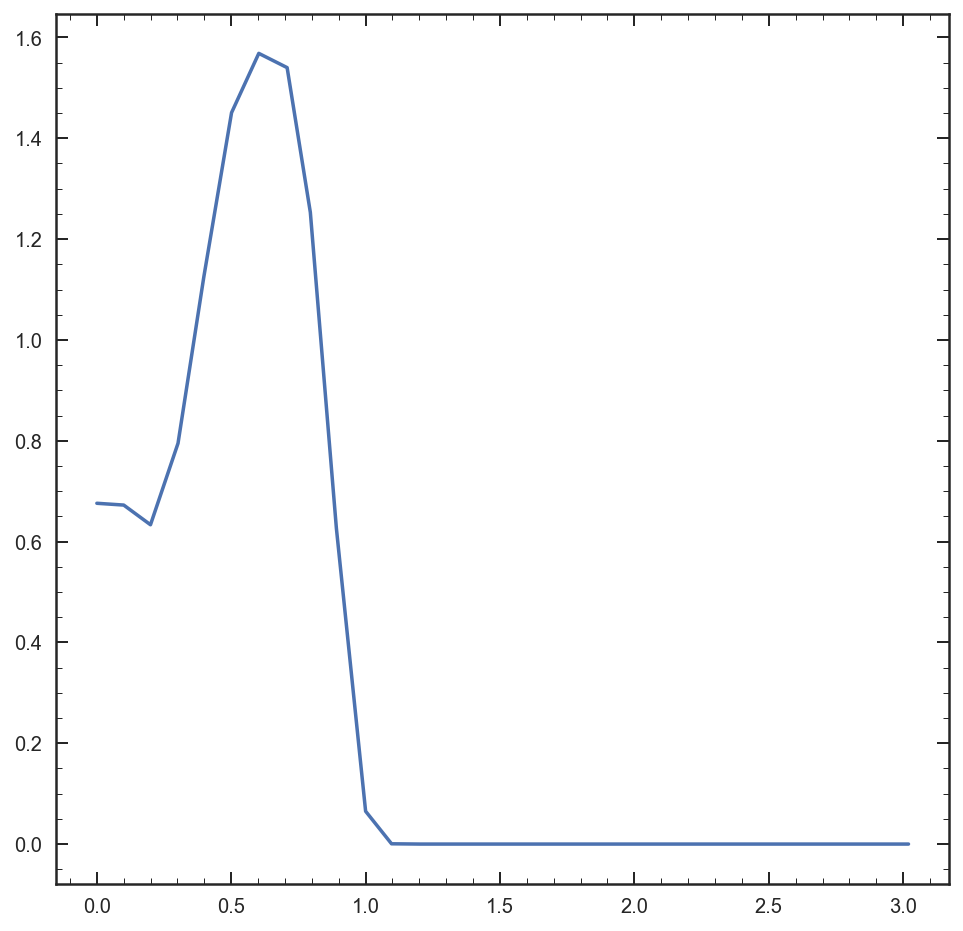

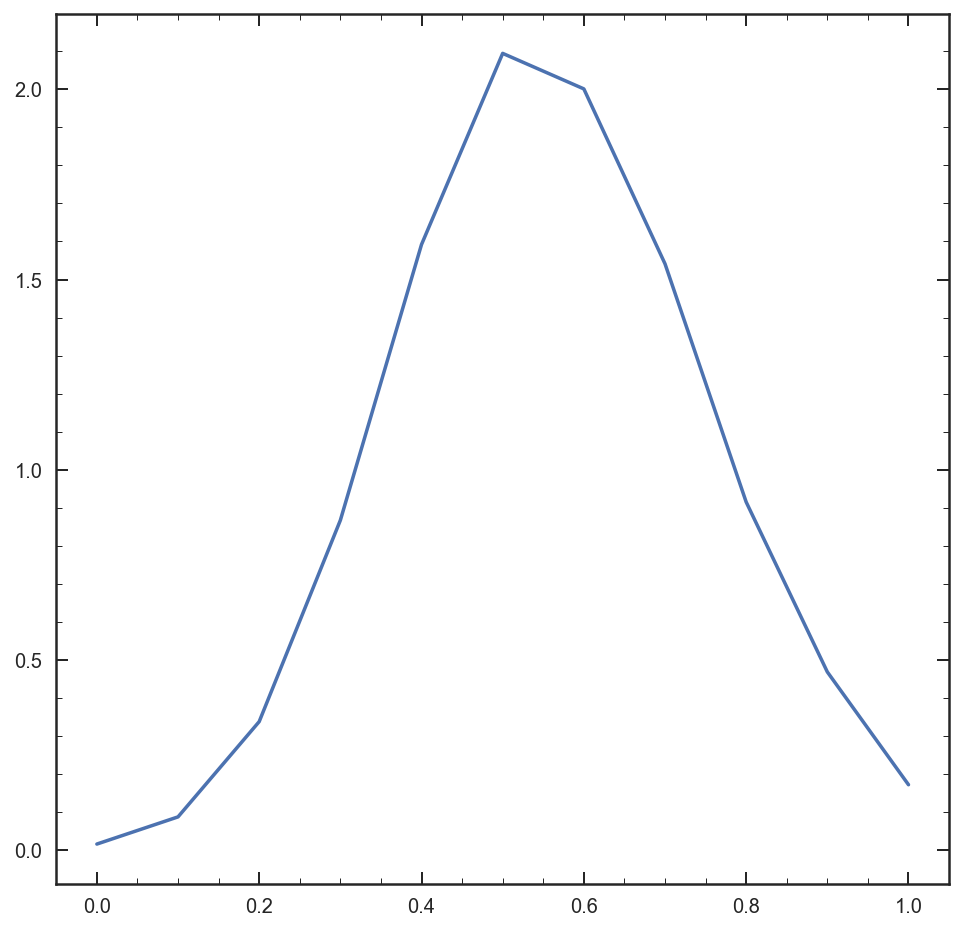

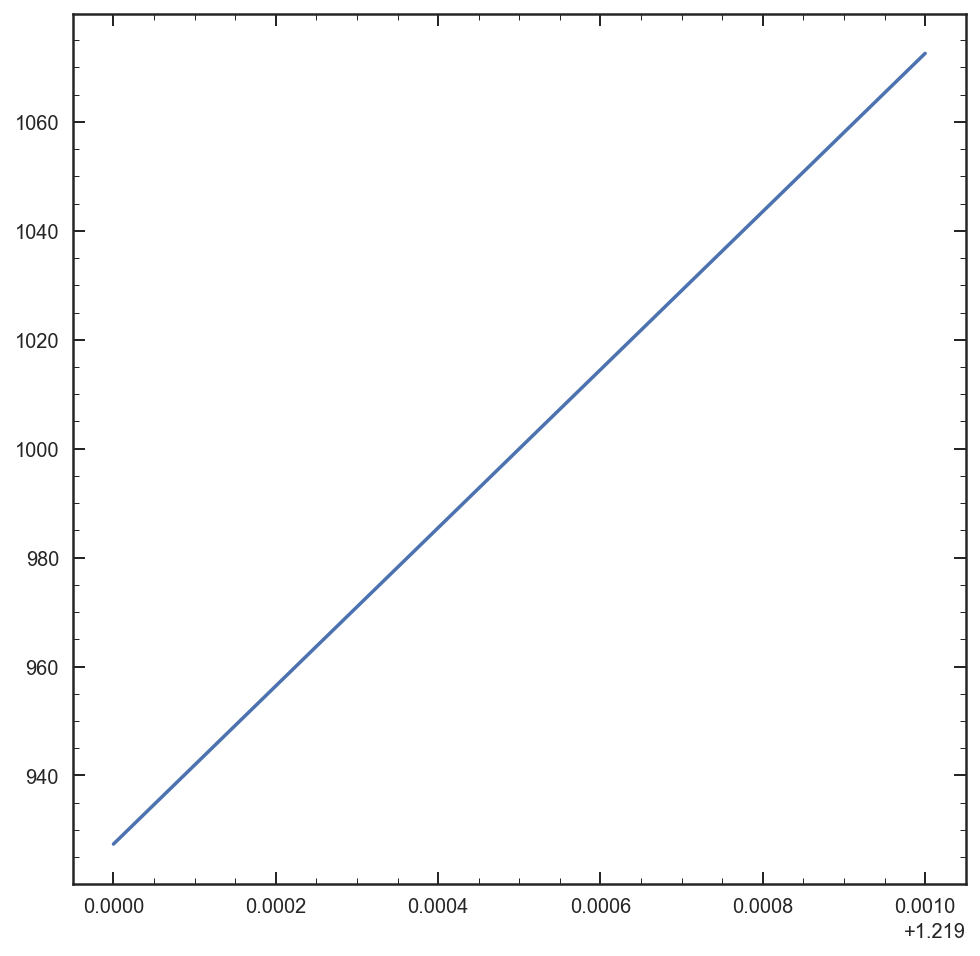

In [28]:
plt.figure(figsize=[8,8])
plt.plot(t,Pt)
plt.figure(figsize=[8,8])
plt.plot(Z,PZ)
plt.figure(figsize=[8,8])
plt.plot(ultau,Ptau)
plt.figure(figsize=[8,8])
plt.plot(d,Pd)
plt.figure(figsize=[8,8])
plt.plot(z,Pz)

In [48]:
start = time()
np.load('/Users/Vince.ec/fsps_models_for_fit/fsps_spec/m0.019_a2.0_dt8.0_spec.npy')
end = time()
print(end - start)

0.0021941661834716797


In [58]:
0.0015 * 50000 / 60.

1.25

In [318]:
z,Pz = np.load('../rshift_dat/s39170_hires_Pofz.npy')

In [31]:
def Best_fit_model(name, metal, age, tau, redshift, dust = np.arange(0,1.1,.1)):
    grids = ['../chidat/{0}_d{1}_chidata.npy'.format(name,U) for U in range(11)]
    chi = Stich_grids(grids)
    x = np.argwhere(chi == np.min(chi))[0]
    print(x)
    print(dust[x[0]],metal[x[1]], age[x[2]], tau[x[3]],redshift[x[4]])
    return dust[x[0]],metal[x[1]], age[x[2]], tau[x[3]],redshift[x[4]]

In [32]:
Best_fit_model('all_test',mtest,age,tau,ztest)

[ 6  3 40  8  1]
0.6000000000000001 0.026 4.5 8.9 1.22


(0.6000000000000001, 0.026, 4.5, 8.9, 1.22)

In [ ]:
pd.Da